In [1]:
import numpy as np
import time

from pdag.data_generator import generate_random_partialB, generate_random_MVN_data
from pdag.pdag import PDAG

In [2]:
p = 20
n = 10*p
omega, B, A, G = generate_random_partialB(int(p/4), 
                                          int(2*p/4), 
                                          int(3*p/4),
                                          p = p,
                                          a = 0.3,
                                          b = 0.7,
                                          diag_a = 2,
                                          diag_b = 5,
                                          plot=False)
B = np.array(B)
X = generate_random_MVN_data(n, omega)

In [3]:
pdag4 = PDAG(4)
start = time.time()
Bhat = pdag4.fit(X, 0.001, int(p/4), int(2*p/4), int(3*p/4))
#partial4.parallel_diagnostics(level=4)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Active itr:  1  itr:  1
Active itr:  1  itr:  2
Active itr:  1  itr:  3
Active itr:  1  itr:  4
Active itr:  1  itr:  5
Active itr:  1  itr:  6
Active itr:  1  itr:  7
Active itr:  1  itr:  8
Active itr:  1  itr:  9
True
Active itr:  2  itr:  1
Active itr:  2  itr:  2
Active itr:  2  itr:  3
Active itr:  2  itr:  4
Active itr:  2  itr:  5
Active itr:  2  itr:  6
Active itr:  2  itr:  7
Active itr:  2  itr:  8
Active itr:  2  itr:  9
True
Elapsed (with compilation) = 18.919803142547607


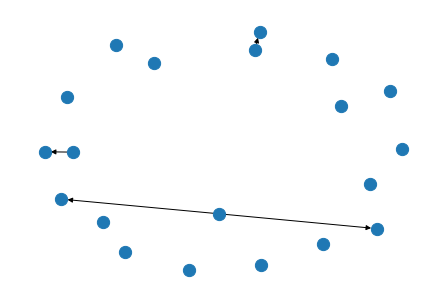

In [4]:
pdag4.plotGraph()